In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
from scipy.integrate import quad

In [2]:
dir = "figures"
os.makedirs(dir, exist_ok=True)

In [3]:
### Data loading

def load_data(filepath):

    try:
        df = pd.read_csv(filepath)
        # Check for standard Oxford Man columns
        if 'Symbol' in df.columns and 'rv5' in df.columns:
            # Clean up dates
            df['Date'] = pd.to_datetime(df['Unnamed: 0'] if 'Unnamed: 0' in df.columns else df.index, utc=True)
            df.set_index('Date', inplace=True)
            return df
        else:
            print("Columns 'Symbol' and 'rv5' exist")
            return None
    except FileNotFoundError:
        print(f"File {filepath} not found")

DATA_FILE = 'data/oxfordmanrealizedvolatilityindices.csv' 
full_data = load_data(DATA_FILE)

In [4]:
full_data.head(6)

,Unnamed: 0,Symbol,rv5_ss,close_time,rsv_ss,open_time,rk_parzen,rv5,rv10_ss,bv,close_price,rv10,open_price,rk_twoscale,medrv,bv_ss,open_to_close,nobs,rsv,rk_th2
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,2000-01-03 00:00:00+00:00,.AEX,0.000130,163015.0,0.000046,90101.0,0.000179,0.000130,0.000178,0.000100,675.44,0.000178,675.67,0.000103,0.000050,0.000100,-0.000340,1795.0,0.000046,0.000102
2000-01-04 00:00:00+00:00,2000-01-04 00:00:00+00:00,.AEX,0.000201,163016.0,0.000147,90416.0,0.000423,0.000201,0.000261,0.000207,642.25,0.000261,664.20,0.000199,0.000075,0.000207,-0.033606,1785.0,0.000147,0.000201
2000-01-05 00:00:00+00:00,2000-01-05 00:00:00+00:00,.AEX,0.000491,163016.0,0.000328,90016.0,0.000324,0.000491,0.000714,0.000361,632.31,0.000714,633.37,0.000325,0.000166,0.000361,-0.001675,1801.0,0.000328,0.000345
2000-01-06 00:00:00+00:00,2000-01-06 00:00:00+00:00,.AEX,0.000225,163002.0,0.000116,90016.0,0.000219,0.000225,0.000182,0.000258,624.21,0.000182,632.46,0.000218,0.000152,0.000258,-0.013130,1799.0,0.000116,0.000221
2000-01-07 00:00:00+00:00,2000-01-07 00:00:00+00:00,.AEX,0.000138,163016.0,0.000048,90046.0,0.000155,0.000138,0.000157,0.000130,644.86,0.000157,628.93,0.000126,0.000039,0.000130,0.025013,1798.0,0.000048,0.000123
2000-01-10 00:00:00+00:00,2000-01-10 00:00:00+00:00,.AEX,0.000109,163017.0,0.000062,90146.0,0.000086,0.000109,0.000126,0.000089,655.14,0.000126,651.82,0.000074,0.000032,0.000089,0.005081,1794.0,0.000062,0.000073


---
### Fractional Stochastic Volatility (FSV) vs Rough Fractional Stochastic Volatility (RFSV)

In the **fractional stochastic volatility (FSV)** model, the asset price and
log-volatility dynamics are given by

$$
\begin{aligned}
\frac{dS_t}{S_t} &= \sigma_t \, dZ_t, \\
d \log \sigma_t &= -\alpha \bigl(\log \sigma_t - \theta\bigr)\,dt
                 + \gamma \, d\hat{W}_t^H ,
\end{aligned}
$$

where:
- $\alpha > 0$ controls mean reversion of log-volatility,
- $\theta$ is the long-run mean,
- $\gamma$ is the volatility-of-volatility parameter.

The driving fractional noise is defined as

$$
\hat W_t^H
=
\int_0^t
\frac{(t-s)^{H-\frac{1}{2}}}{\Gamma(H+\frac{1}{2})}
\, dW_s,
\qquad
\frac{1}{2} \le H < 1,
$$

and the Brownian motions satisfy

$$
\mathbb{E}[dW_t \, dZ_t] = \rho \, dt .
$$

---

### Log-Volatility Increments

Both FSV and RFSV imply the relation

$$
\log \sigma_{t+\Delta} - \log \sigma_t
=
\nu \bigl(W^H_{t+\Delta} - W^H_t\bigr),
$$

which governs the scaling behavior of log-volatility increments.

However, this process is **not stationary** unless mean reversion is introduced.

---

### Stationarity and Model Differences

Stationarity is desirable:
- for mathematical tractability,
- to avoid divergence at large time horizons,
- and to match empirical volatility behavior.

The **RFSV model** can be viewed as a *stationary counterpart* of the FSV model,
formally similar in structure but operating in a different regime.

### Key Differences

| Feature | RFSV | FSV |
|------|------|-----|
| Hurst exponent | $H < \tfrac{1}{2}$ | $H > \tfrac{1}{2}$ |
| Mean reversion | $\alpha T \gg 1$ | $\alpha T \sim 1$ |
| Memory source | Roughness | Long memory |
| Asymptotic scaling | Pure power law | Flattening at large lags |

Here, $T$ denotes a typical timescale of interest.

---

### Long Memory in the FSV Model

In the FSV framework, one typically chooses

$$
H > \frac{1}{2},
$$

motivated by the long-standing empirical observation that volatility
exhibits **long memory**.

In this technical sense, *long memory* means that the autocorrelation function
of volatility decays as a power law:

$$
\mathrm{Corr}(\sigma_t, \sigma_{t+\Delta})
\sim
\Delta^{2H-2},
\qquad \Delta \to \infty .
$$

This motivates fractional dynamics but comes at the cost of introducing
mean reversion to preserve stationarity.

---

### Empirical Scaling: FSV vs RFSV

Empirically, the second-order moment of log-volatility increments is defined as

$$
m(2,\Delta)
=
\mathbb{E}
\bigl[
(\log \sigma_{t+\Delta} - \log \sigma_t)^2
\bigr].
$$

### RFSV Scaling

Under the RFSV model,

$$
m(2,\Delta)
\sim
\nu^2 \Delta^{2H},
$$

leading to a **linear scaling law** in $\log$–$\log$ coordinates.

### FSV Scaling

In contrast, the FSV model implies

$$
m_{\mathrm{FSV}}(2,\Delta)
=
2 \, (\mathrm{Var} - \mathrm{Cov}(\Delta)),
$$

where the covariance term admits the spectral representation

$$
\mathrm{Cov}(\Delta)
\propto
\int_0^\infty
\frac{(1 - \cos(\Delta x)) \, x^{1-2H}}
{\alpha^2 + x^2}
\, dx .
$$

Due to mean reversion ($\alpha > 0$), the FSV curve **flattens at large lags**,
in contrast to the persistent power-law scaling of RFSV.


Estimated H from q=2 slope: 0.1426


/var/folders/c5/5xrh1cx90sq0syx0xry3fzqr0000gn/T/ipykernel_63082/1285024575.py:49: IntegrationWarning: The maximum number of subdivisions (200) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, error = quad(func, 0, np.inf, limit=200)


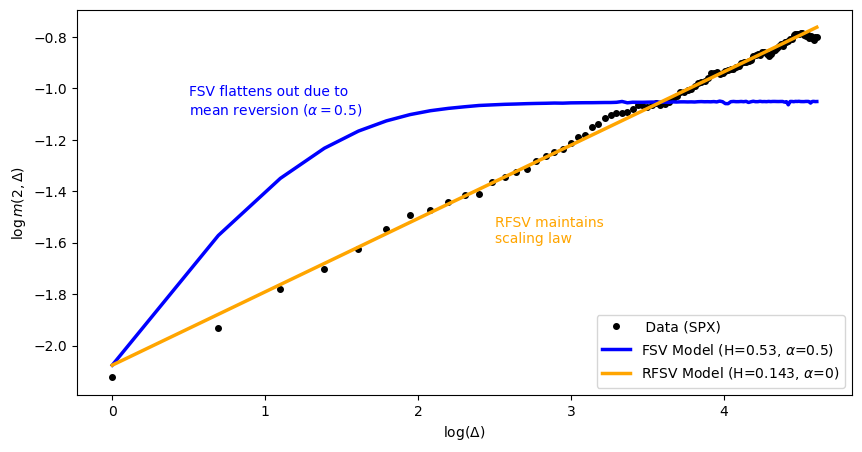

In [5]:
spx_data = full_data[full_data['Symbol'] == '.SPX'].copy()
rv_col = 'rv5'
spx_rv = spx_data[rv_col]
spx_rv = spx_rv[spx_rv > 0]

# CALCULATE EMPIRICAL m(2, Delta)
# m(2, Delta) = Mean[ (log(sigma_{t+Delta}) - log(sigma_t))^2 ]

lags = np.arange(1, 101) # Delta from 1 to 100 days
log_sig = np.log(np.sqrt(spx_rv)) # log vol

m2_empirical = []
for lag in lags:
    diffs = log_sig.diff(lag).dropna()
    m2_empirical.append(np.mean(diffs**2)) # mean over t

m2_empirical = np.array(m2_empirical)

###--------------------- RFSV Model ----------------------
# log(m(q, Delta)) ~ q * H * log(Delta) + C
# For q=2: slope = 2 * H

log_lags = np.log(lags)
log_m2 = np.log(m2_empirical)

slope, intercept_rfsv, _, _, _ = stats.linregress(log_lags, log_m2)

# Calculate H from the slope
H_est = slope / 2.0
print(f"Estimated H from q=2 slope: {H_est:.4f}")

# RFSV curve based on estimation
# m ~ exp(C)* Delta^(slope=2H)
m2_rfsv = np.exp(intercept_rfsv) * (lags ** slope)

###--------------------- FSV Model -------------------------
### B. FSV Model (alpha = 0.5, H = 0.53) H> 0.5 in FSV model
# m_FSV(2, Delta) = 2 * (Var - Cov)
# Cov(Delta) ~ to Integral[ (1 - cos(Delta*x)) * |x|^(1-2H) / (alpha^2 + x^2) ]

H_fsv = 0.53     # Means Long memory persists
alpha_fsv = 0.5  # mean reversion rate of OU process

def fsv_integral(delta, alpha, h):
    # Integrand: (1 - cos(delta * x)) * x^(1 - 2h) / (alpha^2 + x^2)
    # integrate from 0 to infinity.
    func = lambda x: (1 - np.cos(delta * x)) * (x**(1 - 2*h)) / (alpha**2 + x**2)

    res, error = quad(func, 0, np.inf, limit=200)
    # res, error = quad(func, -np.inf, np.inf, limit=200)
    return res

# Calculate theoretical curve
m2_fsv_unscaled = [fsv_integral(d, alpha_fsv, H_fsv) for d in lags]
m2_fsv_unscaled = np.array(m2_fsv_unscaled)

# Scaling: fit the FSV model to match the scale of the data.
# Scale it so it starts at the same point as the RFSV model (at lag 1)
scale_fsv = m2_rfsv[0] / m2_fsv_unscaled[0]
m2_fsv = m2_fsv_unscaled * scale_fsv

#PLOTTING (Log-Log)

plt.figure(figsize=(10, 5))

### Data
plt.plot(np.log(lags), np.log(m2_empirical), 'ko', markersize=4, label=' Data (SPX)')

## FSV Model - Long Memory
plt.plot(np.log(lags), np.log(m2_fsv), 'b-', linewidth=2.5, 
            label=f'FSV Model (H={H_fsv}, $\\alpha$={alpha_fsv})')

### RFSV Model  - Rough Volatility
plt.plot(np.log(lags), np.log(m2_rfsv), 'orange', linewidth=2.5, 
            label=f'RFSV Model (H={H_est:.3f}, $\\alpha$=0)')

plt.xlabel(r'$\log(\Delta)$')
plt.ylabel(r'$\log m(2, \Delta)$')
plt.legend(loc='lower right')

plt.text(0.5, -1.1, "FSV flattens out due to\nmean reversion ($\\alpha=0.5$)", color='blue', fontsize=10)
plt.text(2.5, -1.6, "RFSV maintains\nscaling law", color='orange', fontsize=10)

# plt.savefig(f"{dir}/fig_6.png", dpi=200, bbox_inches='tight',
#             pad_inches=0.1, facecolor='white', edgecolor='none')

plt.show()